<a href="https://colab.research.google.com/github/123prashanth123/Fault-Detection-System/blob/main/FDS%20KMeans%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

In [ ]:
from IPython.display import clear_output

!pip install --upgrade imgaug
!pip install imagecorruptions

clear_output()

In [ ]:
import os
import cv2
import re
import random as r
from time import time

import imgaug
from imgaug import augmenters

import numpy as np
import matplotlib.pyplot as plt

import torch, torchvision
from torch import nn, optim
from torchvision import models, transforms, ops
from torch.utils.data import DataLoader as DL
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def breaker(num=50, char="*"):
    print("\n" + num*char + "\n")

# Constants

In [ ]:
SIZE = 224
SEED = 0
FEA_TRANSFORM = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), ])
DET_TRANSFORN = transforms.Compose([transforms.ToTensor(), ])
SPLIT = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FV_LENGTH = 2048

# Build Pretrained Models

In [ ]:
def build_pretrained_models():
    breaker()
    print("Building Pretrained Models ....")

    class RoIExtractor(nn.Module):
        def __init__(self):
            super(RoIExtractor, self).__init__()
            self.model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, progress=True)
        
        def forward(self, x):
            return self.model(x)


    class FeatureExtractor(nn.Module):
        def __init__(self):
            super(FeatureExtractor, self).__init__()

            self.model = models.vgg16_bn(pretrained=True, progress=True)
            self.model = nn.Sequential(*[*self.model.children()][:-2])
            self.model.add_module("Adaptive Average Pool", nn.AdaptiveAvgPool2d(output_size=(2, 2)))
            self.model.add_module("Flatten", nn.Flatten())
        
        def forward(self, x):
            return self.model(x)

    fea_extractor = FeatureExtractor()
    fea_extractor.eval()
    roi_extractor = RoIExtractor()
    roi_extractor.eval()

    return fea_extractor, roi_extractor

# Build Features

In [ ]:
def build_features(p_image: np.ndarray, n_image: np.ndarray, num_samples=64, batch_size=64):
    
    class FEDS(Dataset):
        def __init__(self, X=None, transform=None):
            self.transform = transform
            self.X = X
        
        def __len__(self):
            return self.X.shape[0]
        
        def __getitem__(self, idx):
            return self.transform(self.X[idx])
    

    def get_augments(augment_seed=None): 
        breaker()
        print("Building Augmentation Pipeline ....")
        imgaug.seed(entropy=augment_seed)
        dataset_augment = augmenters.Sequential([
            augmenters.HorizontalFlip(p=0.25),
            augmenters.VerticalFlip(p=0.25),
            augmenters.SomeOf(5, [
                augmenters.blur.GaussianBlur(sigma=(0, 5), seed=augment_seed),
                augmenters.blur.MedianBlur(k=(1, 7), seed=augment_seed),
                augmenters.size.Crop(percent=(0, 0.15), seed=augment_seed),
                augmenters.geometric.Affine(rotate=(-45, 45), scale=(0.75, 1.25), translate_percent=(-0.15, 0.15), seed=augment_seed),
                augmenters.geometric.Rot90(k=(1, 3), seed=augment_seed),
                augmenters.arithmetic.Dropout(p=(0, 0.075), seed=augment_seed),
                augmenters.arithmetic.SaltAndPepper(p=(0, 0.075), seed=augment_seed),
                augmenters.color.MultiplyBrightness(mul=(0.5, 1.5)),
                augmenters.color.MultiplySaturation(mul=(0, 5), seed=augment_seed),
                augmenters.iaa_convolutional.Sharpen(alpha=(0.75, 1), lightness=(0.75, 1.25), seed=augment_seed),
                augmenters.iaa_convolutional.Emboss(alpha=(0.75, 1), strength=(0.75, 1.25), seed=augment_seed),
                augmenters.contrast.CLAHE(seed=augment_seed),
                augmenters.contrast.GammaContrast(gamma=(0.2, 5), seed=augment_seed),
            ])
        ])

        return dataset_augment
    

    def make_data(num_samples: int , batch_size: int, image: np.ndarray, fea_extractor=None, dataset_augment=None):

        def normalize(x):
            for i in range(x.shape[0]):
                x[i] = (x[i] - torch.min(x[i])) / (torch.max(x[i]) - torch.min(x[i]))
            return x
        images = np.array(dataset_augment(images=[image for _ in range(num_samples)]))

        feature_data_setup = FEDS(X=images, transform=FEA_TRANSFORM)
        feature_data = DL(feature_data_setup, batch_size=batch_size, shuffle=False)
        features = torch.empty(0, FV_LENGTH).to(DEVICE)

        for X in feature_data:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = fea_extractor(X)
            features = torch.cat((features, output), dim=0)
        
        return normalize(features).detach().cpu().numpy(), images


    breaker()
    print("Building Features ....")

    fea_extractor, _ = build_pretrained_models()
    fea_extractor.to(DEVICE)
    r.seed(SEED)

    dataset_augment = get_augments(SEED)

    p_features, p_images = make_data(num_samples, batch_size, p_image, fea_extractor, dataset_augment)
    n_features, n_images = make_data(num_samples, batch_size, n_image, fea_extractor, dataset_augment)

    images = np.concatenate((p_images, n_images), axis=0)
    features = np.concatenate((p_features, n_features), axis=0)
    labels = np.concatenate((np.ones((len(p_features), ), dtype=np.uint8), np.zeros((len(n_features), ), dtype=np.uint8)), axis=0)

    np.random.seed(SEED)
    np.random.shuffle(images)

    np.random.seed(SEED)
    np.random.shuffle(features)

    np.random.seed(SEED)
    np.random.shuffle(labels)

    return images, features, labels

In [ ]:
def KMEANS(images, features, labels):
    breaker()
    print("K-means Analysis ....")

    kmeans = KMeans(n_clusters=2, init="k-means++", random_state=SEED)  
    y_pred = kmeans.fit_predict(features)

    breaker()
    print("Accuracy : {:.5f}".format(accuracy_score(y_pred, labels)))

    breaker()
    num_samples = 10
    print("First {} Prediction Samples   : {}".format(num_samples, y_pred[:num_samples]))
    print("First {} Ground Truth Samples : {}\n".format(num_samples, labels[:num_samples]))

    plt.figure(figsize=(16, 20))
    for i in range(num_samples):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i])
    plt.show()

# Main


**************************************************

Building Features ....

**************************************************

Building Pretrained Models ....


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth




**************************************************

Building Augmentation Pipeline ....

**************************************************

Time Taken : 7.03 minutes

**************************************************

K-means Analysis ....

**************************************************

Accuracy : 0.46287

**************************************************

First 10 Prediction Samples   : [0 1 1 1 0 1 0 0 1 0]
First 10 Ground Truth Samples : [1 1 1 0 1 1 1 1 1 1]



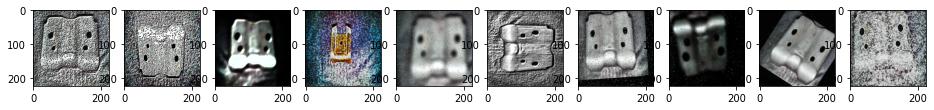

In [ ]:
def main():
    def BGR2RGB(image: np.ndarray) -> np.ndarray:
        return cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
    
    def downscale(image: np.ndarray) -> np.ndarray:
        return cv2.resize(src=image, dsize=(SIZE, SIZE), interpolation=cv2.INTER_AREA)

    p_name = "Snapshot_2.png"
    n_name = "Snapshot_4.png"

    p_image = downscale(BGR2RGB(cv2.imread("/content/" + p_name, cv2.IMREAD_COLOR)))
    n_image = downscale(BGR2RGB(cv2.imread("/content/" + n_name, cv2.IMREAD_COLOR)))

    start_time = time()
    images, features, labels = build_features(num_samples=15000, batch_size=64, p_image=p_image, n_image=n_image)
    breaker()
    print("Time Taken : {:.2f} minutes".format((time() - start_time)/60))

    KMEANS(images, features, labels)
    breaker()


main()